# Week 3

In [1]:
# =============================
# Standard Libraries
# =============================
import os
import time
import math
import io
import zipfile
import requests
from urllib.parse import urlparse
from itertools import chain, combinations
from joblib import parallel_backend
from tqdm.auto import tqdm
import kagglehub
from IPython.display import display
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
import logging
logging.getLogger("optuna").setLevel(logging.WARNING)
import json


# =============================
# Data Science Libraries
# =============================
import numpy as np
import pandas as pd
import optuna
import scipy.stats as stats

# =============================
# Visualization
# =============================
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.ticker as mticker
import seaborn as sns

# =============================
# Scikit-learn
# =============================
from sklearn.model_selection import (
    train_test_split,
    cross_val_score,
    GridSearchCV,
    RandomizedSearchCV,
    RepeatedKFold,
    ParameterGrid,
)
import sklearn.model_selection._search as sk_search
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.feature_selection import SequentialFeatureSelector, f_regression, SelectKBest
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, RidgeClassifier, LogisticRegression
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, GradientBoostingRegressor, RandomForestClassifier, GradientBoostingClassifier
from sklearn.pipeline import Pipeline
import sklearn.model_selection._validation as sk_validation
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV, ElasticNet, ElasticNetCV
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.cross_decomposition import PLSRegression
from sklearn.decomposition import PCA
from sklearn.utils import resample
from sklearn.exceptions import NotFittedError

# =============================
# Global
# =============================
random_state = 42
N_ROWS = 5_000_000  # sample size for all datasets
pd.set_option("display.float_format", lambda x: f"{x:.6f}")

# =============================
# Utils
# =============================
def dollar_format(x, pos=None):
    return f"${x:,.0f}"

def format_hms(seconds):
    return time.strftime("%H:%M:%S", time.gmtime(seconds))

def try_read_csv(folder, fname, **kwargs):
    fp = os.path.join(folder, fname)
    return pd.read_csv(fp, **kwargs) if os.path.exists(fp) else None

def list_csvs(folder):
    return [f for f in os.listdir(folder) if f.lower().endswith(".csv")]

def simple_random_sample(steam, n_rows=None, frac=None, random_state=42):
    if steam is None:
        raise ValueError("steam is None")
    n = len(steam)
    if (n_rows is None) == (frac is None):
        raise ValueError("pass exactly one of n_rows or frac")
    if frac is not None:
        if not (0 < frac <= 1):
            raise ValueError("frac must be in (0, 1]")
        k = int(np.floor(frac * n))
    else:
        if int(n_rows) <= 0:
            raise ValueError("n_rows must be > 0")
        k = min(int(n_rows), n)
    if k >= n:
        return steam.copy()
    t0 = time.perf_counter()
    rng = np.random.default_rng(random_state)
    idx = rng.choice(n, size=k, replace=False)
    out = steam.iloc[idx].copy()
    t1 = time.perf_counter()
    print({"rows": n, "picked": int(len(out)), "frac": float(len(out) / n), "elapsed_sec": round(t1 - t0, 3)})
    return out

def stratified_sample(steam, y, n_rows=None, frac=None, random_state=42):
    if steam is None:
        raise ValueError("steam is None")
    y_arr = steam[y].to_numpy() if isinstance(y, str) else np.asarray(y)
    n = len(steam)
    if len(y_arr) != n:
        raise ValueError("X and y length mismatch")
    if n_rows is not None and frac is not None:
        frac = None
    if n_rows is None and frac is None:
        raise ValueError("provide n_rows or frac")
    if frac is not None:
        if not (0 < frac <= 1):
            raise ValueError("frac must be in (0, 1]")
        test_size = float(frac)
        use_frac, use_n = frac, None
    else:
        if int(n_rows) <= 0:
            raise ValueError("n_rows must be > 0")
        test_size = min(float(n_rows) / n, 1.0)
        use_frac, use_n = None, int(n_rows)
    if test_size >= 1.0:
        return steam.copy()
    _, counts = np.unique(y_arr, return_counts=True)
    if np.any(counts < 2):
        print("Warning: some classes <2 samples; using simple sampling.")
        return simple_random_sample(steam, n_rows=use_n, frac=use_frac, random_state=random_state)
    t0 = time.perf_counter()
    idx = np.arange(n)
    _, test_idx, _, _ = train_test_split(
        idx, y_arr, test_size=test_size, stratify=y_arr, random_state=random_state
    )
    out = steam.iloc[test_idx].copy()
    t1 = time.perf_counter()
    print(
        {
            "rows": n,
            "picked": int(len(out)),
            "frac": float(len(out) / n),
            "elapsed_sec": round(t1 - t0, 3),
            "mode": "stratified",
        }
    )
    return out

# =============================
# Load Steam (sample first)
# =============================
steam_path = kagglehub.dataset_download("antonkozyriev/game-recommendations-on-steam")
print("Steam path:", steam_path, "\n", os.listdir(steam_path))

games = try_read_csv(steam_path, "games.csv", low_memory=False)
users = try_read_csv(steam_path, "users.csv", low_memory=False)
recommendations = try_read_csv(steam_path, "recommendations.csv", low_memory=False)

metadata = None
meta_fp = os.path.join(steam_path, "games_metadata.json")
if os.path.exists(meta_fp):
    metadata = pd.read_json(meta_fp, lines=True)

print(
    "Steam shapes:",
    {
        "games": None if games is None else games.shape,
        "users": None if users is None else users.shape,
        "recommendations": None if recommendations is None else recommendations.shape,
        "metadata": None if metadata is None else metadata.shape,
    },
)

steam = None
if recommendations is not None:
    # sample recommendations
    if "is_recommended" in recommendations.columns:
        recs_sample = stratified_sample(recommendations, y="is_recommended", n_rows=N_ROWS, random_state=random_state)
    else:
        recs_sample = simple_random_sample(recommendations, n_rows=N_ROWS, random_state=random_state)

    gm = games
    if metadata is not None and "app_id" in metadata.columns and games is not None and "app_id" in games.columns:
        gm = games.merge(metadata, on="app_id", how="left")

    steam = recs_sample
    if gm is not None and "app_id" in recs_sample.columns and "app_id" in gm.columns:
        steam = steam.merge(gm, on="app_id", how="left")
    if users is not None and "user_id" in steam.columns and "user_id" in users.columns:
        steam = steam.merge(users, on="user_id", how="left")

    print("steam:", steam.shape)

# =============================
# Load Olist
# =============================
olist_path = kagglehub.dataset_download("olistbr/brazilian-ecommerce")
print("\nOlist path:", olist_path, "\n", os.listdir(olist_path))

olist_customers = try_read_csv(olist_path, "olist_customers_dataset.csv")
olist_geolocation = try_read_csv(olist_path, "olist_geolocation_dataset.csv")
olist_items = try_read_csv(olist_path, "olist_order_items_dataset.csv")
olist_payments = try_read_csv(olist_path, "olist_order_payments_dataset.csv")
olist_reviews = try_read_csv(olist_path, "olist_order_reviews_dataset.csv")
olist_orders = try_read_csv(olist_path, "olist_orders_dataset.csv")
olist_products = try_read_csv(olist_path, "olist_products_dataset.csv")
olist_sellers = try_read_csv(olist_path, "olist_sellers_dataset.csv")
olist_cat_trans = try_read_csv(olist_path, "product_category_name_translation.csv")

print(
    "Olist shapes:",
    {
        "customers": None if olist_customers is None else olist_customers.shape,
        "geolocation": None if olist_geolocation is None else olist_geolocation.shape,
        "items": None if olist_items is None else olist_items.shape,
        "payments": None if olist_payments is None else olist_payments.shape,
        "reviews": None if olist_reviews is None else olist_reviews.shape,
        "orders": None if olist_orders is None else olist_orders.shape,
        "products": None if olist_products is None else olist_products.shape,
        "sellers": None if olist_sellers is None else olist_sellers.shape,
        "category_translation": None if olist_cat_trans is None else olist_cat_trans.shape,
    },
)

olist = None
if all(x is not None for x in [olist_orders, olist_customers, olist_items, olist_products, olist_sellers]):
    # translated category names
    if olist_cat_trans is not None and "product_category_name" in olist_products.columns:
        products_en = olist_products.merge(olist_cat_trans, on="product_category_name", how="left")
    else:
        products_en = olist_products

    # enrich items with product and seller info
    items_ext = (
        olist_items.merge(products_en, on="product_id", how="left")
        .merge(olist_sellers, on="seller_id", how="left", suffixes=("", "_seller"))
    )

    # average lat,lng per ZIP prefix
    if olist_geolocation is not None:
        geo_zip = (
            olist_geolocation.groupby("geolocation_zip_code_prefix", as_index=False).agg(
                geolocation_lat=("geolocation_lat", "mean"),
                geolocation_lng=("geolocation_lng", "mean"),
                geo_points=("geolocation_city", "count"),
            )
        )
        customers_geo = (
            olist_customers.merge(
                geo_zip,
                left_on="customer_zip_code_prefix",
                right_on="geolocation_zip_code_prefix",
                how="left",
            )
            .drop(columns=["geolocation_zip_code_prefix"])
        )
    else:
        customers_geo = olist_customers

    payments_agg = (
        olist_payments.groupby("order_id", as_index=False).agg(
            payment_value_total=("payment_value", "sum"),
            payment_installments_max=("payment_installments", "max"),
            payment_count=("payment_type", "count"),
        )
        if olist_payments is not None
        else None
    )

    reviews_agg = (
        olist_reviews.groupby("order_id", as_index=False).agg(
            review_score_mean=("review_score", "mean"),
            review_count=("review_id", "count"),
        )
        if olist_reviews is not None
        else None
    )

    olist = (
        olist_orders.merge(customers_geo, on="customer_id", how="left")
        .merge(items_ext, on="order_id", how="left")
    )
    if payments_agg is not None:
        olist = olist.merge(payments_agg, on="order_id", how="left")
    if reviews_agg is not None:
        olist = olist.merge(reviews_agg, on="order_id", how="left")

    print("olist:", olist.shape)

    # sample Olist
    olist = simple_random_sample(olist, n_rows=N_ROWS, random_state=random_state)
    print("olist sample:", olist.shape)

# Run immediately after loading/creating `olist`
base_cols = [
    "order_id","customer_id","order_status","order_purchase_timestamp",
    "order_approved_at","order_delivered_carrier_date",
    "order_delivered_customer_date","order_estimated_delivery_date",
    "customer_unique_id","customer_zip_code_prefix","customer_city",
    "customer_state","geolocation_lat","geolocation_lng","geo_points",
    "order_item_id","product_id","seller_id","shipping_limit_date","price",
    "freight_value","product_category_name","product_name_lenght",
    "product_description_lenght","product_photos_qty","product_weight_g",
    "product_length_cm","product_height_cm","product_width_cm",
    "product_category_name_english","seller_zip_code_prefix","seller_city",
    "seller_state","payment_value_total","payment_installments_max",
    "payment_count","review_score_mean","review_count"
]

idx_map = {}
cols_set = set(olist.columns)
for i, name in enumerate(base_cols):
    if i in cols_set:
        idx_map[i] = name
    if str(i) in cols_set:
        idx_map[str(i)] = name

olist = olist.rename(columns=idx_map)


# =============================
# Load Video Games Sales 2019
# =============================
vg2019_path = kagglehub.dataset_download("ashaheedq/video-games-sales-2019")
print("\nVG2019 path:", vg2019_path, "\n", os.listdir(vg2019_path))

sales = None
csvs = list_csvs(vg2019_path)
target_csv = "vgsales-12-4-2019.csv" if "vgsales-12-4-2019.csv" in csvs else (csvs[0] if csvs else None)
if target_csv is not None:
    sales = pd.read_csv(os.path.join(vg2019_path, target_csv), low_memory=False)
    print("sales:", sales.shape, "| file:", target_csv)

    # sample VG2019
    if "Genre" in sales.columns:
        sales = stratified_sample(sales, y="Genre", n_rows=N_ROWS, random_state=random_state)
    else:
        sales = simple_random_sample(sales, n_rows=N_ROWS, random_state=random_state)
    print("sales sample:", sales.shape)
else:
    print("No CSV found in the video-games-sales-2019 dataset.")

# Progress Tracking
from tqdm import tqdm

# =============================
# Global Variables
# =============================
random_state = 42

# =============================
# Utility Functions
# =============================

# Format y-axis labels as dollars with commas (optional)
def dollar_format(x, pos=None):
    return f'${x:,.0f}'

# Convert seconds to HH:MM:SS format
def format_hms(seconds):
    return time.strftime("%H:%M:%S", time.gmtime(seconds))

pd.set_option("display.float_format", lambda x: f"{x:.6f}")


# =============================
# Final summaries
# =============================
print("\nsteam sample:", None if steam is None else steam.shape)
print("olist sample:", None if olist is None else olist.shape)
print("sales sample:", None if sales is None else sales.shape)

Steam path: /Users/chandlercampbell/.cache/kagglehub/datasets/antonkozyriev/game-recommendations-on-steam/versions/28 
 ['recommendations.csv', 'users.csv', 'games.csv', 'games_metadata.json']
Steam shapes: {'games': (50872, 13), 'users': (14306064, 3), 'recommendations': (41154794, 8), 'metadata': (50872, 3)}
{'rows': 41154794, 'picked': 5000000, 'frac': 0.12149252891412844, 'elapsed_sec': 6.169, 'mode': 'stratified'}
steam: (5000000, 24)

Olist path: /Users/chandlercampbell/.cache/kagglehub/datasets/olistbr/brazilian-ecommerce/versions/2 
 ['olist_sellers_dataset.csv', 'product_category_name_translation.csv', 'olist_orders_dataset.csv', 'olist_order_items_dataset.csv', 'olist_customers_dataset.csv', 'olist_geolocation_dataset.csv', 'olist_order_payments_dataset.csv', 'olist_order_reviews_dataset.csv', 'olist_products_dataset.csv']
Olist shapes: {'customers': (99441, 5), 'geolocation': (1000163, 5), 'items': (112650, 7), 'payments': (103886, 5), 'reviews': (99224, 7), 'orders': (99441

In [2]:
# Forward Feature Selection
def forward_feature_selection(X, y, model,
                              scoring="neg_mean_absolute_error",
                              cv=3,
                              tol=None,
                              max_features=None,
                              n_jobs=-1,
                              verbose=False):
    # support DataFrame or ndarray
    try:
        feature_names = list(X.columns)
        X_arr = X.values
    except AttributeError:
        X_arr = X
        feature_names = [f"f{i}" for i in range(X_arr.shape[1])]

    selected_idx = []
    remaining_idx = list(range(X_arr.shape[1]))
    best_scores = []
    previous_score = float("inf")

    best_feature_set_idx = []
    best_score = float("inf")

    while remaining_idx:
        scores = {}
        for idx in remaining_idx:
            trial_idx = selected_idx + [idx]
            cv_score = -cross_val_score(
                model,
                X_arr[:, trial_idx],
                y,
                scoring=scoring,
                cv=cv,
                n_jobs=n_jobs
            ).mean()
            scores[idx] = cv_score

        best_idx = min(scores, key=scores.get)
        current_score = scores[best_idx]

        # stop if improvement below tol
        if tol is not None and previous_score - current_score < tol:
            if verbose:
                print("Stopping early (improvement < tol).")
            break

        selected_idx.append(best_idx)
        remaining_idx.remove(best_idx)
        best_scores.append(current_score)
        previous_score = current_score

        if verbose:
            name = feature_names[best_idx]
            print(f"Added {name} → CV score = {current_score:.4f}")

        if current_score < best_score:
            best_score = current_score
            best_feature_set_idx = selected_idx.copy()

        if max_features is not None and len(selected_idx) >= max_features:
            break

    selected_features = [feature_names[i] for i in selected_idx]
    best_feature_set = [feature_names[i] for i in best_feature_set_idx]
    # Plot the results
    index = np.argmax(np.array(selected_features) == best_feature_set[-1])

    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(best_scores) + 1), best_scores, marker='.')
    plt.plot([index+1],best_score,marker='x',color='red')
    plt.xticks(range(1, len(selected_features) + 1), selected_features, rotation=60, ha='right', fontsize=6)
    plt.title('Forward Feature Selection and CV Scores')
    plt.xlabel('Features Added')
    plt.ylabel('CV Score (MAE)')
    plt.grid()
    plt.tight_layout()
    plt.show()

    # Print the best subset and score
    print(f"Best Features: {best_feature_set}")
    print(f"Best CV MAE Score: {best_score:.4f}")

    return selected_features, best_scores, best_feature_set, best_score

In [3]:
# Backward Selection
def backward_feature_selection(X, y, model,
                               scoring="neg_mean_absolute_error",
                               cv=3,
                               tol=None,
                               min_features=1,
                               n_jobs=-1,
                               verbose=False):
    # support DataFrame or ndarray
    try:
        feature_names = list(X.columns)
        X_arr = X.values
    except AttributeError:
        X_arr = X
        feature_names = [f"f{i}" for i in range(X_arr.shape[1])]

    selected_idx = list(range(X_arr.shape[1]))
    removed_names = []     # <-- track removed feature names
    best_scores = []

    # baseline with all features
    previous_score = -cross_val_score(
        model,
        X_arr[:, selected_idx],
        y,
        scoring=scoring,
        cv=cv,
        n_jobs=n_jobs
    ).mean()
    best_score = previous_score
    best_feature_set_idx = selected_idx.copy()

    while len(selected_idx) > min_features:
        scores = {}
        for idx in selected_idx:
            trial = [i for i in selected_idx if i != idx]
            cv_score = -cross_val_score(
                model,
                X_arr[:, trial],
                y,
                scoring=scoring,
                cv=cv,
                n_jobs=n_jobs
            ).mean()
            scores[idx] = cv_score

        remove_idx = min(scores, key=scores.get)
        current_score = scores[remove_idx]

        if tol is not None and (previous_score - current_score) < tol:
            if verbose:
                print("Stopping early (improvement < tol).")
            break

        # record removal
        removed_names.append(feature_names[remove_idx])
        selected_idx.remove(remove_idx)
        best_scores.append(current_score)

        if verbose:
            print(f"Removed {feature_names[remove_idx]} → CV score = {current_score:.4f}")

        previous_score = current_score
        if current_score < best_score:
            best_score = current_score
            best_feature_set_idx = selected_idx.copy()

    selected_features = [feature_names[i] for i in selected_idx]
    best_feature_set = [feature_names[i] for i in best_feature_set_idx]

    # --- plotting with removed feature names on x-axis ---
    steps = len(best_scores)
    if steps > 0:
        x = np.arange(1, steps + 1)
        plt.figure(figsize=(10, 6))
        plt.plot(x, best_scores, marker=".")
        # mark best point
        best_step = best_scores.index(best_score) + 1
        plt.plot([best_step], [best_score], marker="x", color="red")
        plt.xticks(x, removed_names, rotation=60, ha="right", fontsize=6)
        plt.title("Backward Feature Selection and CV Scores")
        plt.xlabel("Feature Removed")
        plt.ylabel("CV Score (MAE)")
        plt.grid()
        plt.tight_layout()
        plt.show()

    print(f"Best Features: {best_feature_set}")
    print(f"Best CV MAE Score: {best_score:.4f}")

    return selected_features, best_scores, best_feature_set, best_score

# Steam Reviews

In [4]:
steam.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000000 entries, 0 to 4999999
Data columns (total 24 columns):
 #   Column          Dtype  
---  ------          -----  
 0   app_id          int64  
 1   helpful         int64  
 2   funny           int64  
 3   date            object 
 4   is_recommended  bool   
 5   hours           float64
 6   user_id         int64  
 7   review_id       int64  
 8   title           object 
 9   date_release    object 
 10  win             bool   
 11  mac             bool   
 12  linux           bool   
 13  rating          object 
 14  positive_ratio  int64  
 15  user_reviews    int64  
 16  price_final     float64
 17  price_original  float64
 18  discount        float64
 19  steam_deck      bool   
 20  description     object 
 21  tags            object 
 22  products        int64  
 23  reviews         int64  
dtypes: bool(5), float64(4), int64(9), object(6)
memory usage: 748.6+ MB


In [5]:
X_train, X_test, y_train, y_test = train_test_split(steam.drop("positive_ratio", axis=1), steam["positive_ratio"], test_size=0.2, random_state=random_state)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.select_dtypes(include=["int", "float"]))
X_test_scaled = scaler.transform(X_test.select_dtypes(include=["int", "float"]))

Added app_id → CV score = 8.1457
Added price_original → CV score = 8.1197
Added hours → CV score = 8.0886
Added reviews → CV score = 8.0746
Added price_final → CV score = 8.0681
Added discount → CV score = 8.0624
Added user_reviews → CV score = 8.0581
Added products → CV score = 8.0547
Added user_id → CV score = 8.0536
Added helpful → CV score = 8.0529
Added funny → CV score = 8.0527
Added review_id → CV score = 8.0554


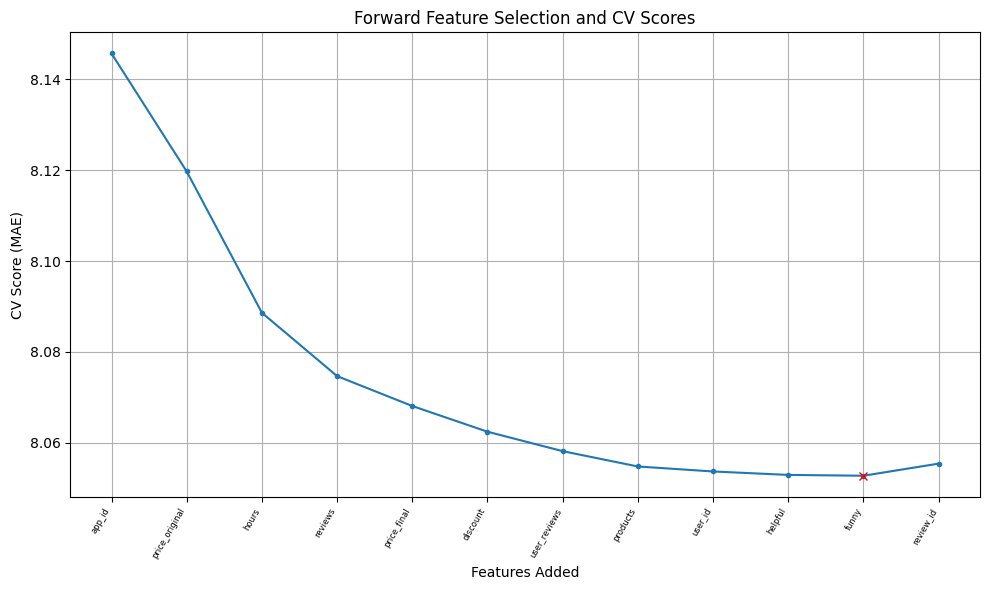

Best Features: ['app_id', 'price_original', 'hours', 'reviews', 'price_final', 'discount', 'user_reviews', 'products', 'user_id', 'helpful', 'funny']
Best CV MAE Score: 8.0527


In [6]:
numeric_features = X_train.select_dtypes(include=["int", "float"]).columns

X_train_scaled_df = pd.DataFrame(
    X_train_scaled,
    columns=numeric_features,
    index=X_train.index
)

model = LinearRegression()
forward_selected_features, forward_best_scores, forward_best_subset, forward_best_score = forward_feature_selection(
    X_train_scaled_df, 
    y_train, 
    model, 
    verbose=True
)

Removed review_id → CV score = 8.0527
Removed funny → CV score = 8.0529
Removed helpful → CV score = 8.0536
Removed user_id → CV score = 8.0547
Removed products → CV score = 8.0581
Removed user_reviews → CV score = 8.0624
Removed discount → CV score = 8.0681
Removed price_final → CV score = 8.0746
Removed reviews → CV score = 8.0886
Removed hours → CV score = 8.1197
Removed price_original → CV score = 8.1457


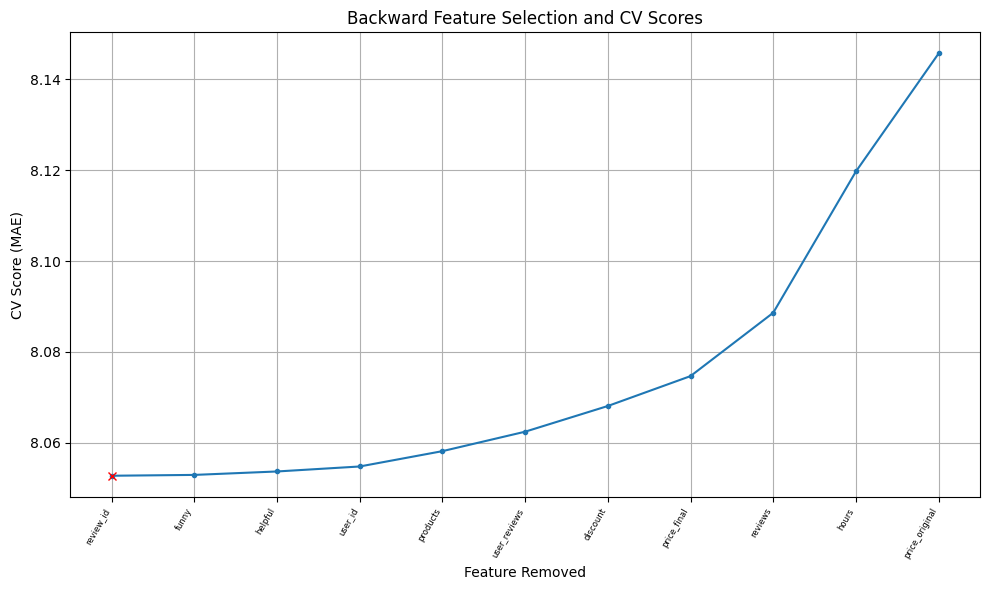

Best Features: ['app_id', 'helpful', 'funny', 'hours', 'user_id', 'user_reviews', 'price_final', 'price_original', 'discount', 'products', 'reviews']
Best CV MAE Score: 8.0527


In [7]:
X_train_scaled_df = pd.DataFrame(
    X_train_scaled,
    columns=numeric_features,
    index=X_train.index
)

model = LinearRegression()
backward_selected_features, backward_best_scores, backward_best_subset, backward_best_score = backward_feature_selection(
    X_train_scaled_df, 
    y_train, 
    model, 
    verbose=True
)

Best PCR components: 12 with MAE: 8.051151
Best PLS components: 5 with MAE: 8.051093


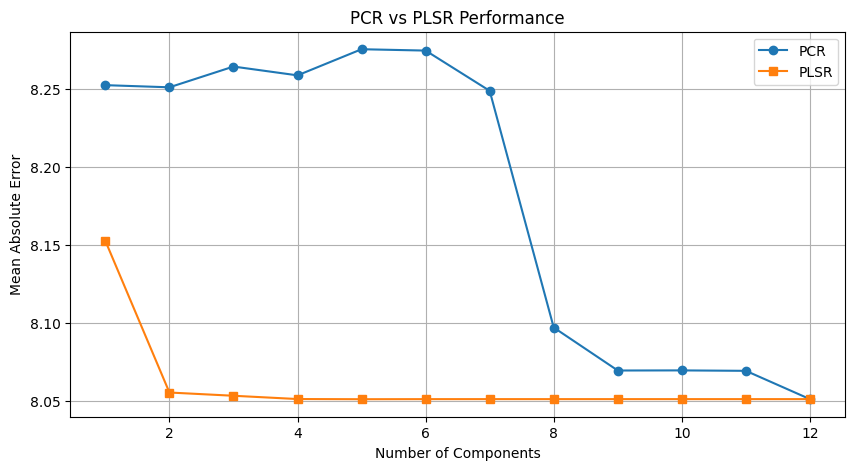

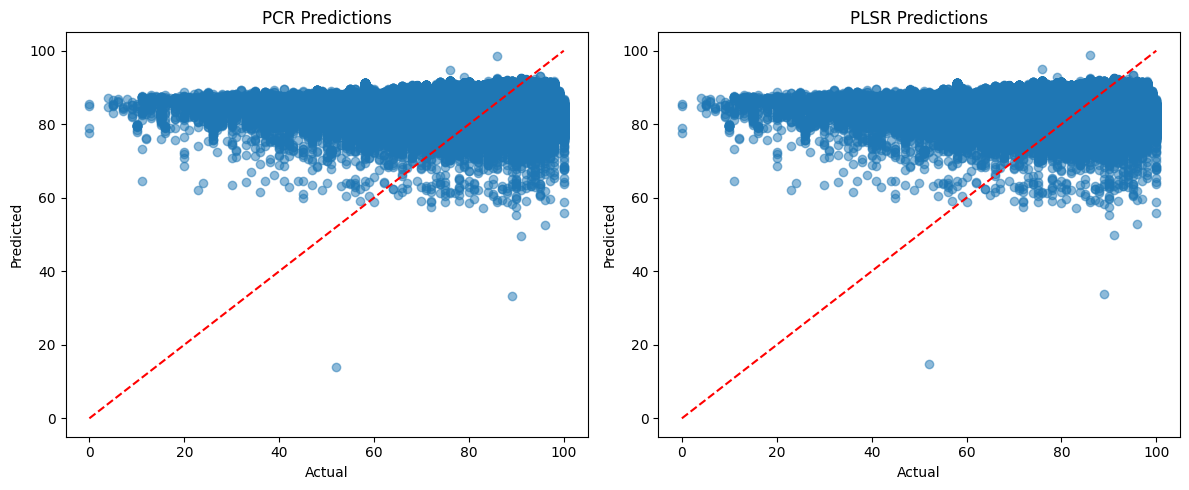

In [8]:
# PCR vs PLSR 

# Make scaled DataFrames with the same numeric columns
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=numeric_features, index=X_train.index)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=numeric_features, index=X_test.index)

# Limit components to available features
max_components = min(X_train_scaled_df.shape[1], 12)

pcr_mae = []
pls_mae = []

for n in range(1, max_components + 1):
    # PCR on scaled numeric features
    pca = PCA(n_components=n)
    X_train_pca = pca.fit_transform(X_train_scaled_df)
    X_test_pca = pca.transform(X_test_scaled_df)
    reg = LinearRegression().fit(X_train_pca, y_train)
    y_pred_pcr = reg.predict(X_test_pca)
    pcr_mae.append(mean_absolute_error(y_test, y_pred_pcr))

    # PLSR on the same scaled numeric features
    pls = PLSRegression(n_components=n)
    pls.fit(X_train_scaled_df, y_train)
    y_pred_pls = pls.predict(X_test_scaled_df).ravel()
    pls_mae.append(mean_absolute_error(y_test, y_pred_pls))

# Best number of components
best_pcr = int(np.argmin(pcr_mae) + 1)
best_pls = int(np.argmin(pls_mae) + 1)

print(f"Best PCR components: {best_pcr} with MAE: {pcr_mae[best_pcr-1]:.6f}")
print(f"Best PLS components: {best_pls} with MAE: {pls_mae[best_pls-1]:.6f}")

# Error curves
plt.figure(figsize=(10, 5))
plt.plot(range(1, max_components + 1), pcr_mae, marker="o", label="PCR")
plt.plot(range(1, max_components + 1), pls_mae, marker="s", label="PLSR")
plt.xlabel("Number of Components")
plt.ylabel("Mean Absolute Error")
plt.title("PCR vs PLSR Performance")
plt.legend()
plt.grid(True)
plt.show()

# Retrain best models for scatter plots
pca = PCA(n_components=best_pcr)
X_train_pca = pca.fit_transform(X_train_scaled_df)
X_test_pca = pca.transform(X_test_scaled_df)
reg = LinearRegression().fit(X_train_pca, y_train)
y_pred_pcr = reg.predict(X_test_pca)

pls = PLSRegression(n_components=best_pls).fit(X_train_scaled_df, y_train)
y_pred_pls = pls.predict(X_test_scaled_df).ravel()

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred_pcr, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "r--")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("PCR Predictions")

plt.subplot(1, 2, 2)
plt.scatter(y_test, y_pred_pls, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "r--")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("PLSR Predictions")

plt.tight_layout()
plt.show()


# Olist Transactions

In [9]:
olist.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113425 entries, 0 to 113424
Data columns (total 38 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   order_id                       113425 non-null  object 
 1   customer_id                    113425 non-null  object 
 2   order_status                   113425 non-null  object 
 3   order_purchase_timestamp       113425 non-null  object 
 4   order_approved_at              113264 non-null  object 
 5   order_delivered_carrier_date   111457 non-null  object 
 6   order_delivered_customer_date  110196 non-null  object 
 7   order_estimated_delivery_date  113425 non-null  object 
 8   customer_unique_id             113425 non-null  object 
 9   customer_zip_code_prefix       113425 non-null  int64  
 10  customer_city                  113425 non-null  object 
 11  customer_state                 113425 non-null  object 
 12  geolocation_lat               

In [10]:
olist = olist.dropna()

In [11]:
X_train, X_test, y_train, y_test = train_test_split(olist.drop("price", axis=1), olist["price"], test_size=0.2, random_state=random_state)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.select_dtypes(include=["int", "float"]))
X_test_scaled = scaler.transform(X_test.select_dtypes(include=["int", "float"]))

Added payment_value_total → CV score = 51.0931
Added order_item_id → CV score = 44.4227
Added product_weight_g → CV score = 44.0682
Added payment_installments_max → CV score = 43.7108
Added seller_zip_code_prefix → CV score = 43.6192
Added customer_zip_code_prefix → CV score = 43.6040
Added product_height_cm → CV score = 43.5901
Added geolocation_lng → CV score = 43.5889
Added geo_points → CV score = 43.5882
Added review_count → CV score = 43.5876
Added product_name_lenght → CV score = 43.5911
Added payment_count → CV score = 43.5953
Added geolocation_lat → CV score = 43.6020
Added product_width_cm → CV score = 43.6104
Added product_length_cm → CV score = 43.7135
Added product_description_lenght → CV score = 43.8053
Added product_photos_qty → CV score = 43.8866
Added review_score_mean → CV score = 44.1189
Added freight_value → CV score = 44.4783


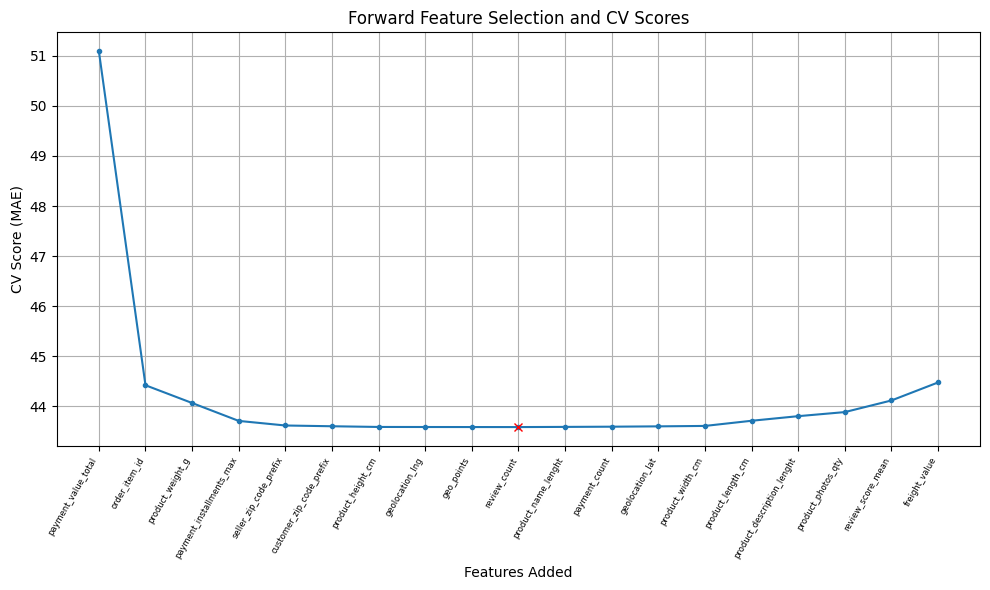

Best Features: ['payment_value_total', 'order_item_id', 'product_weight_g', 'payment_installments_max', 'seller_zip_code_prefix', 'customer_zip_code_prefix', 'product_height_cm', 'geolocation_lng', 'geo_points', 'review_count']
Best CV MAE Score: 43.5876


In [12]:
numeric_features = X_train.select_dtypes(include=["int", "float"]).columns

X_train_scaled_df = pd.DataFrame(
    X_train_scaled,
    columns=numeric_features,
    index=X_train.index
)

model = LinearRegression()
forward_selected_features, forward_best_scores, forward_best_subset, forward_best_score = forward_feature_selection(
    X_train_scaled_df.dropna(axis=1), 
    y_train.dropna(), 
    model, 
    verbose=True
)

Removed freight_value → CV score = 44.1189
Removed review_score_mean → CV score = 43.8866
Removed product_length_cm → CV score = 43.7828
Removed product_photos_qty → CV score = 43.7139
Removed product_description_lenght → CV score = 43.6104
Removed product_width_cm → CV score = 43.6020
Removed geolocation_lat → CV score = 43.5953
Removed payment_count → CV score = 43.5911
Removed product_name_lenght → CV score = 43.5876
Removed review_count → CV score = 43.5882
Removed geo_points → CV score = 43.5889
Removed geolocation_lng → CV score = 43.5901
Removed product_height_cm → CV score = 43.6040
Removed customer_zip_code_prefix → CV score = 43.6192
Removed seller_zip_code_prefix → CV score = 43.7108
Removed payment_installments_max → CV score = 44.0682
Removed product_weight_g → CV score = 44.4227
Removed order_item_id → CV score = 51.0931


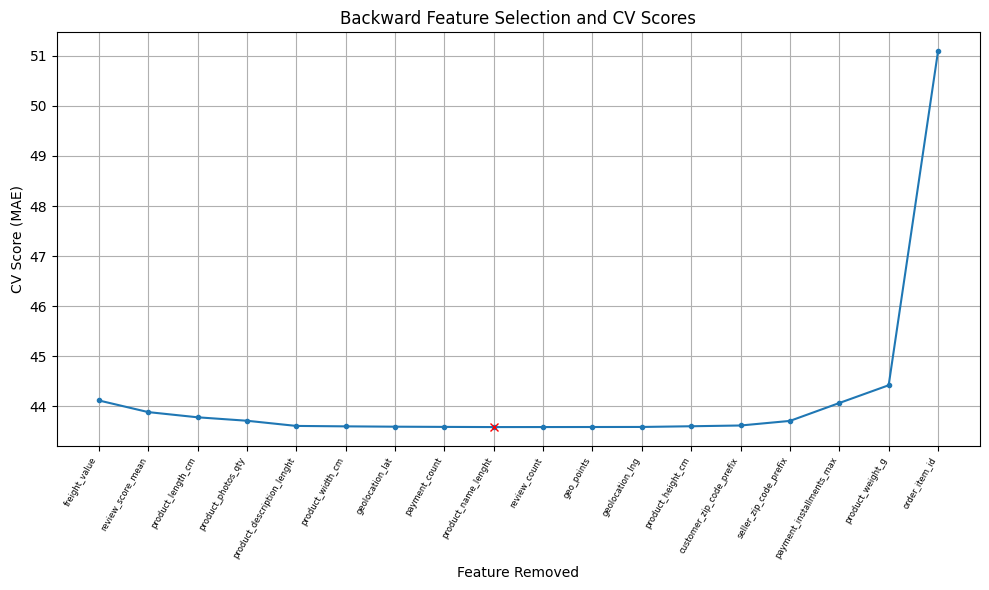

Best Features: ['customer_zip_code_prefix', 'geolocation_lng', 'geo_points', 'order_item_id', 'product_weight_g', 'product_height_cm', 'seller_zip_code_prefix', 'payment_value_total', 'payment_installments_max', 'review_count']
Best CV MAE Score: 43.5876


In [13]:
model = LinearRegression()
backward_selected_features, backward_best_scores, backward_best_subset, backward_best_score = backward_feature_selection(
    X_train_scaled_df, 
    y_train, 
    model, 
    verbose=True
)

Best PCR components: 12 with MAE: 74.997220
Best PLS components: 5 with MAE: 45.292305


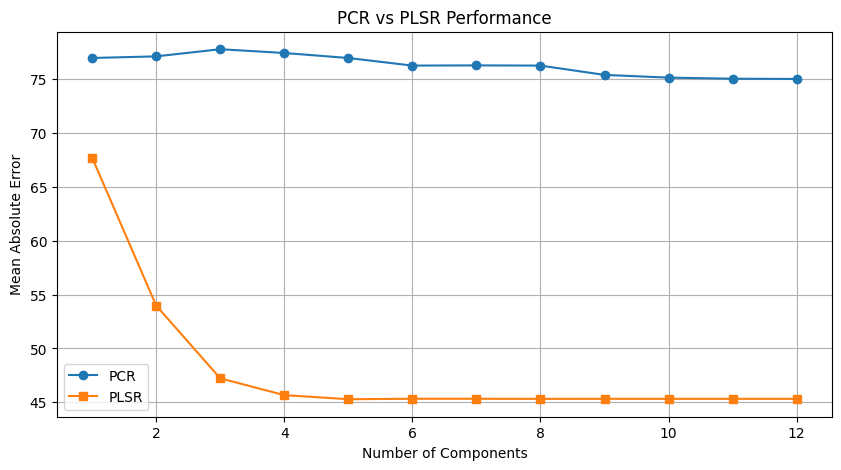

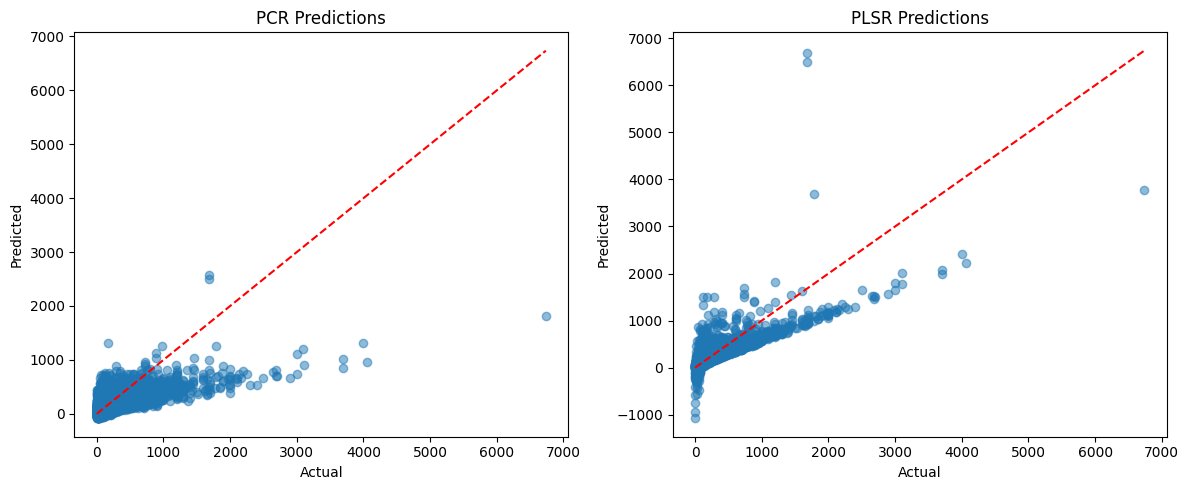

In [14]:
# PCR vs PLSR

# Make scaled DataFrames with the same numeric columns
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=numeric_features, index=X_train.index)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=numeric_features, index=X_test.index)

# Limit components to available features
max_components = min(X_train_scaled_df.shape[1], 12)

pcr_mae = []
pls_mae = []

for n in range(1, max_components + 1):
    # PCR on scaled numeric features
    pca = PCA(n_components=n)
    X_train_pca = pca.fit_transform(X_train_scaled_df)
    X_test_pca = pca.transform(X_test_scaled_df)
    reg = LinearRegression().fit(X_train_pca, y_train)
    y_pred_pcr = reg.predict(X_test_pca)
    pcr_mae.append(mean_absolute_error(y_test, y_pred_pcr))

    # PLSR on the same scaled numeric features
    pls = PLSRegression(n_components=n)
    pls.fit(X_train_scaled_df, y_train)
    y_pred_pls = pls.predict(X_test_scaled_df).ravel()
    pls_mae.append(mean_absolute_error(y_test, y_pred_pls))

# Best number of components
best_pcr = int(np.argmin(pcr_mae) + 1)
best_pls = int(np.argmin(pls_mae) + 1)

print(f"Best PCR components: {best_pcr} with MAE: {pcr_mae[best_pcr-1]:.6f}")
print(f"Best PLS components: {best_pls} with MAE: {pls_mae[best_pls-1]:.6f}")

# Error curves
plt.figure(figsize=(10, 5))
plt.plot(range(1, max_components + 1), pcr_mae, marker="o", label="PCR")
plt.plot(range(1, max_components + 1), pls_mae, marker="s", label="PLSR")
plt.xlabel("Number of Components")
plt.ylabel("Mean Absolute Error")
plt.title("PCR vs PLSR Performance")
plt.legend()
plt.grid(True)
plt.show()

# Retrain best models for scatter plots
pca = PCA(n_components=best_pcr)
X_train_pca = pca.fit_transform(X_train_scaled_df)
X_test_pca = pca.transform(X_test_scaled_df)
reg = LinearRegression().fit(X_train_pca, y_train)
y_pred_pcr = reg.predict(X_test_pca)

pls = PLSRegression(n_components=best_pls).fit(X_train_scaled_df, y_train)
y_pred_pls = pls.predict(X_test_scaled_df).ravel()

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred_pcr, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "r--")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("PCR Predictions")

plt.subplot(1, 2, 2)
plt.scatter(y_test, y_pred_pls, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "r--")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("PLSR Predictions")

plt.tight_layout()
plt.show()


# Video Game Sales

In [15]:
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55792 entries, 0 to 55791
Data columns (total 23 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Rank            55792 non-null  int64  
 1   Name            55792 non-null  object 
 2   basename        55792 non-null  object 
 3   Genre           55792 non-null  object 
 4   ESRB_Rating     23623 non-null  object 
 5   Platform        55792 non-null  object 
 6   Publisher       55792 non-null  object 
 7   Developer       55775 non-null  object 
 8   VGChartz_Score  0 non-null      float64
 9   Critic_Score    6536 non-null   float64
 10  User_Score      335 non-null    float64
 11  Total_Shipped   1827 non-null   float64
 12  Global_Sales    19415 non-null  float64
 13  NA_Sales        12964 non-null  float64
 14  PAL_Sales       13189 non-null  float64
 15  JP_Sales        7043 non-null   float64
 16  Other_Sales     15522 non-null  float64
 17  Year            54813 non-null 

In [16]:
pd.set_option("display.float_format", lambda x: f"{x:.6f}")

# start with a copy
df = sales.copy()

# 1) drop leakage and ids
drop_cols = [
    "NA_Sales", "PAL_Sales", "JP_Sales", "Other_Sales",  # regional leakage
    "Rank",                                              # sales rank leaks target
    "url", "img_url"                                     # pure ids
]
for c in drop_cols:
    if c in df.columns:
        df.drop(columns=c, inplace=True)

# 2) drop super-sparse or post-outcome stuff
for c in ["VGChartz_Score", "Vgchartzscore", "User_Score", "Total_Shipped"]:
    if c in df.columns and (df[c].isna().mean() > 0.95 or c in ["Total_Shipped"]):
        df.drop(columns=c, inplace=True)

# 3) keep only rows with a target
df = df[~df["Global_Sales"].isna()].reset_index(drop=True)
y = df["Global_Sales"].astype(float)
df.drop(columns=["Global_Sales"], inplace=True)

# 4) basic cleaning
for c in df.select_dtypes(include="object").columns:
    df[c] = df[c].astype(str).str.strip()

# Year -> int
if "Year" in df.columns:
    df["Year"] = pd.to_numeric(df["Year"], errors="coerce")
    df["Year"] = df["Year"].round().astype("float")

# Last_Update -> year
if "Last_Update" in df.columns:
    lu = pd.to_datetime(df["Last_Update"], errors="coerce", utc=True)
    df["Last_Update_Year"] = lu.dt.year.astype("float")
    df.drop(columns=["Last_Update"], inplace=True)

# 5) simple features
def is_remaster(name):
    s = str(name).lower()
    keys = ["remaster", "hd", "definitive", "anniversary"]
    return 1 if any(k in s for k in keys) else 0

if "Name" in df.columns:
    df["Name_Len"] = df["Name"].astype(str).str.len().astype("float")
    df["Name_Words"] = df["Name"].astype(str).str.split().apply(len).astype("float")
    df["Is_Remaster"] = df["Name"].apply(is_remaster).astype("float")
else:
    df["Name_Len"] = np.nan
    df["Name_Words"] = np.nan
    df["Is_Remaster"] = 0.0

if "basename" in df.columns:
    df["Basename_Len"] = df["basename"].astype(str).str.len().astype("float")
    df["Basename_Words"] = df["basename"].astype(str).str.split().apply(len).astype("float")
else:
    df["Basename_Len"] = np.nan
    df["Basename_Words"] = np.nan

if "Year" in df.columns:
    df["Age"] = 2025 - df["Year"]
else:
    df["Age"] = np.nan

# 6) frequency encodings for high-card columns
for col in ["Publisher", "Developer", "basename"]:
    if col in df.columns:
        counts = df[col].value_counts(dropna=False)
        freq = (counts / len(df)).to_dict()
        df[f"{col}_freq"] = df[col].map(freq).astype("float")

# 7) choose small categoricals to one-hot
low_card = [c for c in ["Genre", "ESRB_Rating", "Platform", "status"] if c in df.columns]

# make sure categoricals have "Unknown" for missing
for c in low_card:
    df[c] = df[c].astype(str).fillna("Unknown").replace({"nan": "Unknown"})

# drop raw text-heavy columns to keep it small
for raw in ["Name", "basename", "Publisher", "Developer"]:
    if raw in df.columns:
        df.drop(columns=raw, inplace=True)

# 8) split numeric vs categorical
cat_df = pd.get_dummies(df[low_card], drop_first=False)
num_cols = [c for c in df.columns if c not in low_card]
num_df = df[num_cols].copy()

# median fill for numeric
for c in num_df.columns:
    if num_df[c].dtype.kind in "if":
        med = num_df[c].median()
        num_df[c] = num_df[c].fillna(med)

# 9) assemble final matrix
X_df = pd.concat([num_df, cat_df], axis=1)

# safety: replace any remaining NaN
X_df = X_df.fillna(0.0)

# outputs
X = X_df.values
feature_names = list(X_df.columns)

print("X shape:", X.shape)
print("y length:", len(y))
print("num features:", len(feature_names))


X shape: (19415, 79)
y length: 19415
num features: 79


In [17]:
X_train_df, X_test_df, y_train, y_test = train_test_split(
    X_df, y, test_size=0.2, random_state=random_state
)

# scale and keep DataFrame structure
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_df)
X_test_scaled = scaler.transform(X_test_df)

X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=feature_names, index=X_train_df.index)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=feature_names, index=X_test_df.index)

Added ESRB_Rating_Unknown → CV score = 0.3828
Added Publisher_freq → CV score = 0.3727
Added basename_freq → CV score = 0.3689
Added Year → CV score = 0.3646
Added ESRB_Rating_M → CV score = 0.3629
Added Platform_NES → CV score = 0.3614
Added Platform_PS → CV score = 0.3601
Added Platform_PS3 → CV score = 0.3594
Added Platform_2600 → CV score = 0.3588
Added Platform_GC → CV score = 0.3586
Added Platform_GB → CV score = 0.3583
Added Platform_SNES → CV score = 0.3581
Added Genre_Strategy → CV score = 0.3580
Added Platform_X360 → CV score = 0.3578
Added Platform_GBC → CV score = 0.3577
Added Genre_Fighting → CV score = 0.3576
Added Genre_Role-Playing → CV score = 0.3576
Added Genre_Sandbox → CV score = 0.3575
Added ESRB_Rating_RP → CV score = 0.3575
Added Platform_WS → CV score = 0.3575
Added Platform_SCD → CV score = 0.3575
Added Platform_VC → CV score = 0.3574
Added Platform_Mob → CV score = 0.3574
Added Genre_MMO → CV score = 0.3574
Added Platform_WW → CV score = 0.3574
Added Genre_Boa

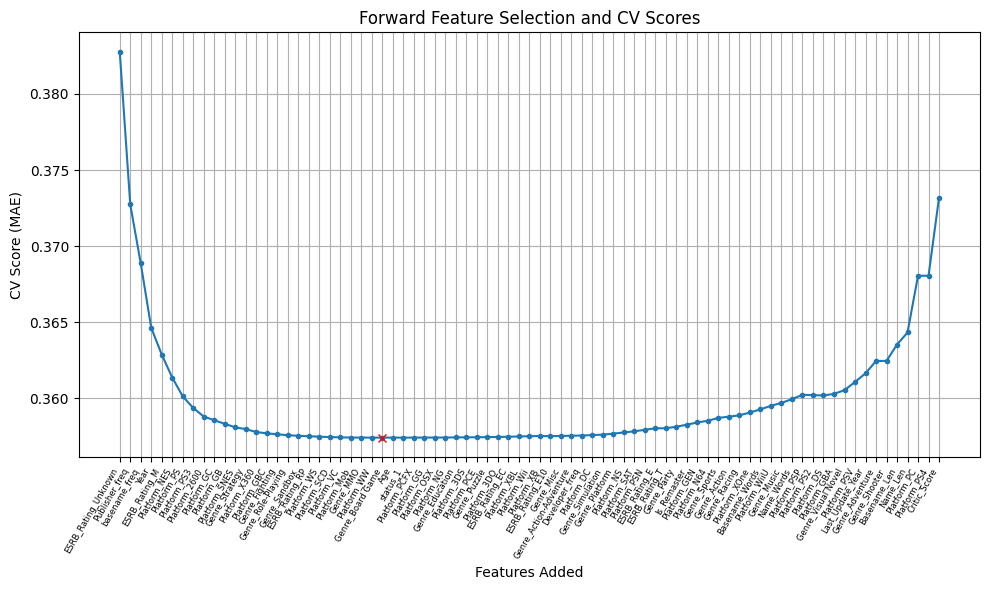

Best Features: ['ESRB_Rating_Unknown', 'Publisher_freq', 'basename_freq', 'Year', 'ESRB_Rating_M', 'Platform_NES', 'Platform_PS', 'Platform_PS3', 'Platform_2600', 'Platform_GC', 'Platform_GB', 'Platform_SNES', 'Genre_Strategy', 'Platform_X360', 'Platform_GBC', 'Genre_Fighting', 'Genre_Role-Playing', 'Genre_Sandbox', 'ESRB_Rating_RP', 'Platform_WS', 'Platform_SCD', 'Platform_VC', 'Platform_Mob', 'Genre_MMO', 'Platform_WW', 'Genre_Board Game']
Best CV MAE Score: 0.3574


In [18]:
model = LinearRegression()
forward_selected_features, forward_best_scores, forward_best_subset, forward_best_score = forward_feature_selection(
    X_train_scaled_df,
    y_train,
    model,
    verbose=True
)

Removed Critic_Score → CV score = 0.3681
Removed Name_Words → CV score = 0.3666
Removed Last_Update_Year → CV score = 0.3662
Removed Is_Remaster → CV score = 0.3661
Removed Name_Len → CV score = 0.3661
Removed Basename_Len → CV score = 0.3660
Removed Basename_Words → CV score = 0.3659
Removed Platform_PCFX → CV score = 0.3659
Removed Genre_Platform → CV score = 0.3659
Removed Genre_Adventure → CV score = 0.3656
Removed Genre_Shooter → CV score = 0.3649
Removed Genre_Music → CV score = 0.3646
Removed Genre_Racing → CV score = 0.3645
Removed Genre_Sports → CV score = 0.3643
Removed Genre_Strategy → CV score = 0.3642
Removed Genre_Party → CV score = 0.3642
Removed Genre_Visual Novel → CV score = 0.3641
Removed Genre_Simulation → CV score = 0.3641
Removed Genre_MMO → CV score = 0.3640
Removed Genre_Fighting → CV score = 0.3640
Removed Genre_Puzzle → CV score = 0.3640
Removed Genre_Education → CV score = 0.3640
Removed Genre_Board Game → CV score = 0.3640
Removed Year → CV score = 0.3640
Re

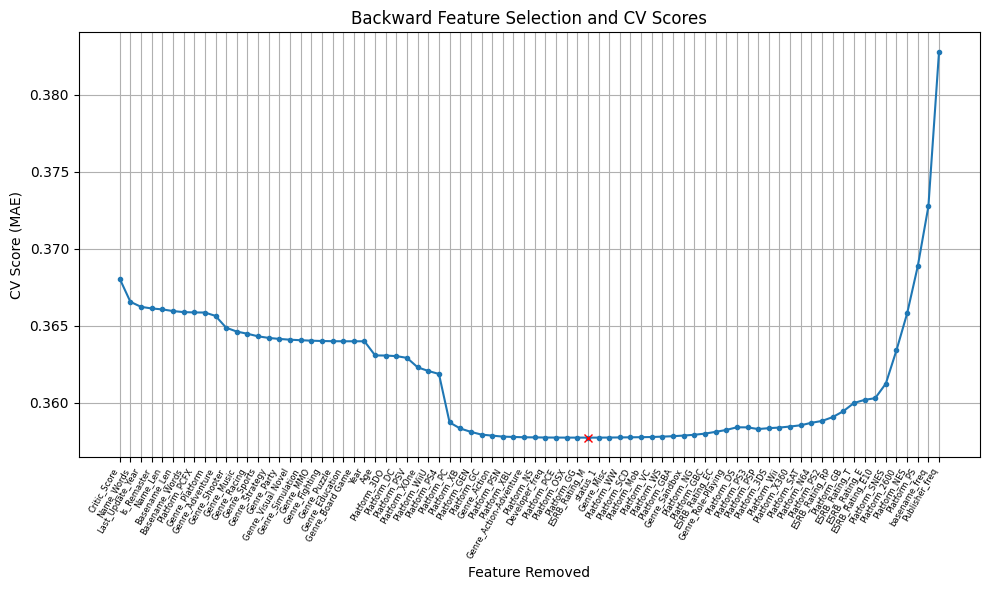

Best Features: ['Publisher_freq', 'basename_freq', 'Genre_Misc', 'Genre_Role-Playing', 'Genre_Sandbox', 'ESRB_Rating_E', 'ESRB_Rating_E10', 'ESRB_Rating_EC', 'ESRB_Rating_RP', 'ESRB_Rating_T', 'ESRB_Rating_Unknown', 'Platform_2600', 'Platform_3DS', 'Platform_DS', 'Platform_GB', 'Platform_GBA', 'Platform_GBC', 'Platform_Mob', 'Platform_N64', 'Platform_NES', 'Platform_NG', 'Platform_PS', 'Platform_PS2', 'Platform_PS3', 'Platform_PSP', 'Platform_SAT', 'Platform_SCD', 'Platform_SNES', 'Platform_VC', 'Platform_WS', 'Platform_WW', 'Platform_Wii', 'Platform_X360', 'status_1']
Best CV MAE Score: 0.3578


In [19]:
model = LinearRegression()
backward_selected_features, backward_best_scores, backward_best_subset, backward_best_score = backward_feature_selection(
    X_train_scaled_df, 
    y_train, 
    model, 
    verbose=True
)

Best PCR components: 11 with MAE: 0.362259
Best PLS components: 2 with MAE: 0.366959


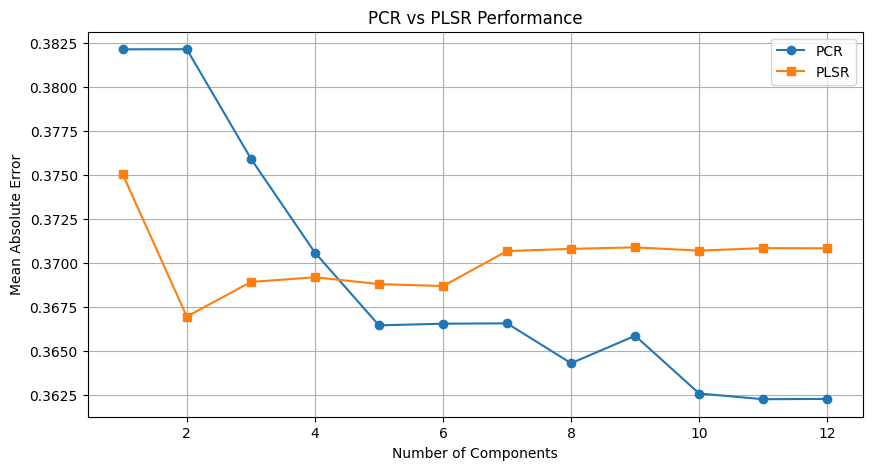

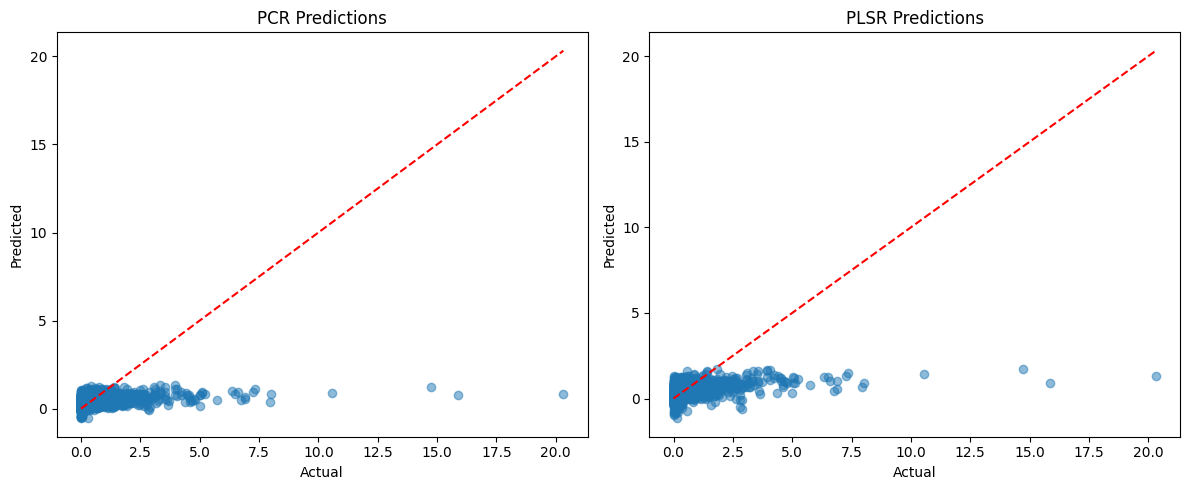

In [20]:
# PCR vs PLSR

# Limit components to available features
max_components = min(X_train_scaled_df.shape[1], 12)

pcr_mae = []
pls_mae = []

for n in range(1, max_components + 1):
    # PCR on scaled numeric features
    pca = PCA(n_components=n)
    X_train_pca = pca.fit_transform(X_train_scaled_df)
    X_test_pca = pca.transform(X_test_scaled_df)
    reg = LinearRegression().fit(X_train_pca, y_train)
    y_pred_pcr = reg.predict(X_test_pca)
    pcr_mae.append(mean_absolute_error(y_test, y_pred_pcr))

    # PLSR on the same scaled numeric features
    pls = PLSRegression(n_components=n)
    pls.fit(X_train_scaled_df, y_train)
    y_pred_pls = pls.predict(X_test_scaled_df).ravel()
    pls_mae.append(mean_absolute_error(y_test, y_pred_pls))

# Best number of components
best_pcr = int(np.argmin(pcr_mae) + 1)
best_pls = int(np.argmin(pls_mae) + 1)

print(f"Best PCR components: {best_pcr} with MAE: {pcr_mae[best_pcr-1]:.6f}")
print(f"Best PLS components: {best_pls} with MAE: {pls_mae[best_pls-1]:.6f}")

# Error curves
plt.figure(figsize=(10, 5))
plt.plot(range(1, max_components + 1), pcr_mae, marker="o", label="PCR")
plt.plot(range(1, max_components + 1), pls_mae, marker="s", label="PLSR")
plt.xlabel("Number of Components")
plt.ylabel("Mean Absolute Error")
plt.title("PCR vs PLSR Performance")
plt.legend()
plt.grid(True)
plt.show()

# Retrain best models for scatter plots
pca = PCA(n_components=best_pcr)
X_train_pca = pca.fit_transform(X_train_scaled_df)
X_test_pca = pca.transform(X_test_scaled_df)
reg = LinearRegression().fit(X_train_pca, y_train)
y_pred_pcr = reg.predict(X_test_pca)

pls = PLSRegression(n_components=best_pls).fit(X_train_scaled_df, y_train)
y_pred_pls = pls.predict(X_test_scaled_df).ravel()

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred_pcr, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "r--")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("PCR Predictions")

plt.subplot(1, 2, 2)
plt.scatter(y_test, y_pred_pls, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "r--")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("PLSR Predictions")

plt.tight_layout()
plt.show()
